# RNN
They are networks with loops in them, allowing information to persist.

Neural network A, looks at some input xt  and outputs a value ht. 

A loop allows information to be passed from  one step of the network to the next.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png" width="150px">

<img src="https://d3ansictanv2wj.cloudfront.net/SentimentAnalysis15-ff3d406a494a92a41b2d5d94a7ed1684.png" width="450px">

First, we start with a simple ** Echo RNN that remembers the input data and then echoes it after a few time-steps:**

In [2]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

Generate the training data, the input is basically a random binary vector. 

The output will be the “echo” of the input, shifted echo_step steps to the right.


In [4]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [5]:
print(generateData())

(array([[1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 1, 0]]), array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 0, 1]]))


### Building the computational graph

In [11]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [12]:
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

- the “batch window” is slided truncated_backprop_length steps to the right at each run

In [13]:
# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

Next let’s build the part of the graph that does the actual RNN computation.

In [16]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat( [current_input, current_state],1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

<img src="https://cdn-images-1.medium.com/max/1400/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png" width="500">

The above code calculates the sum of two affine transforms current_input * Wa + current_state * Wb. By concatenating those two tensors you will only use one matrix multiplication

truncated_backprop_length: The layers will not be unrolled to the beginning of time, that would be too computationally expensive, and are therefore truncated at a limited number of time-steps.

In [ ]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

^a fully connected softmax layer from the state to the output that will make the classes one-hot encoded, and then calculating the loss of the batch.

TensorFlow will perform back-propagation for us automatically — the computation graph is executed once for each mini-batch and the network-weights are updated incrementally.

In [27]:
#plotting helper function
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.show()
    plt.pause(0.0001)

Start training:

In [ ]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            
        if epoch_idx%10 == 0:
            print("Step",batch_idx, "Loss", _total_loss)
            plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

## Using TF RNN API

Instead of manually coding the unpacking of columns and forward pass, we use BasicRNNCell

In [36]:
# Unpack columns
inputs_series = tf.split(batchX_placeholder, int(truncated_backprop_length),1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
cell = tf.contrib.rnn.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

# LSTM

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.

They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.

They work tremendously well on a large variety of problems, and are now widely used.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="500px">


https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Key details about LSTM with TF

- TensorFlow uses a data structure called LSTMStateTuple internally for its LSTM:s, where the first element in the tuple is the cell state, and the second is the hidden state
- The states_series will be a list of hidden states as tensors, and current_state will be a LSTMStateTuple which shows both the hidden- and the cell state on the last time-step

In [37]:
cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state)

Change the function call to create a LSTM and supply the initial state-tuple 

In [39]:
cell = tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

# Whole program
This is the full code for creating a RNN with LSTM.

/home/krohak/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Batch loss 0.692894


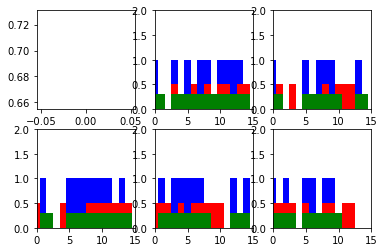

Step 100 Batch loss 0.600943


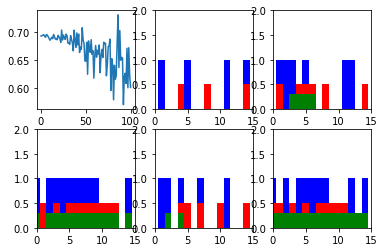

Step 200 Batch loss 0.550755


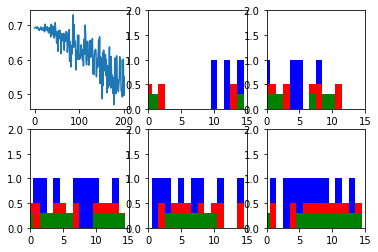

Step 300 Batch loss 0.427746


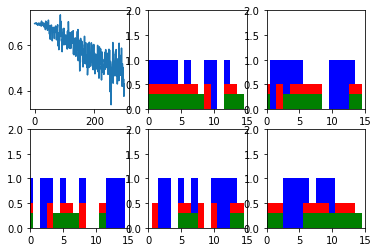

Step 400 Batch loss 0.1971


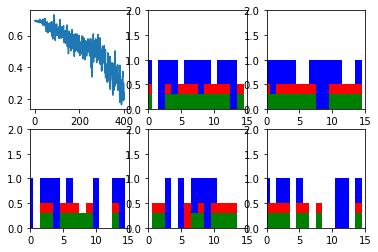

Step 500 Batch loss 0.0319074


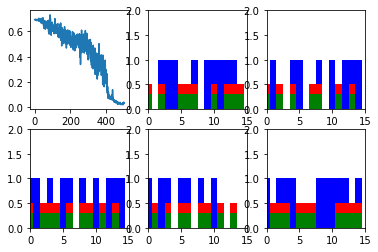

Step 600 Batch loss 0.00734163


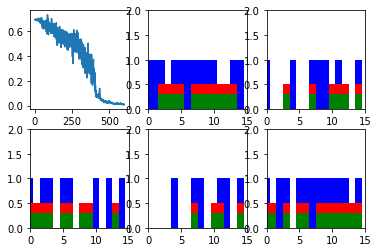

New data, epoch 1
Step 0 Batch loss 0.25246


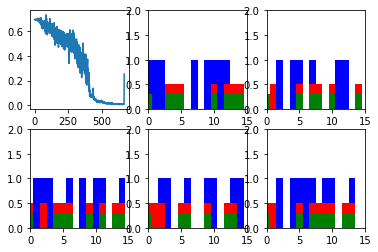

Step 100 Batch loss 0.00628204


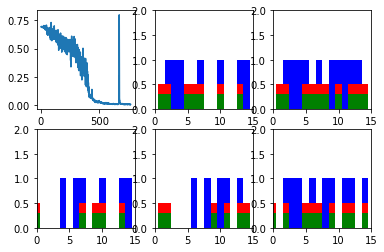

Step 200 Batch loss 0.00366699


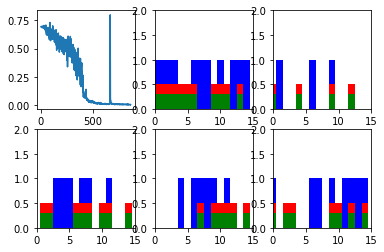

Step 300 Batch loss 0.00383207


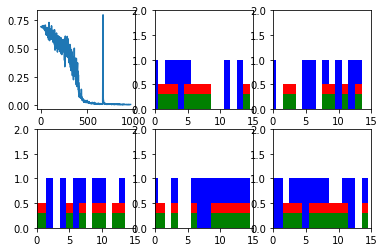

Step 400 Batch loss 0.00346266


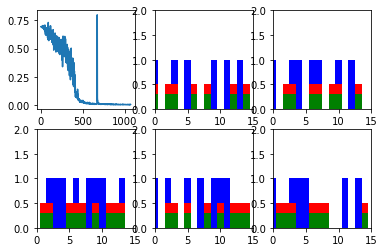

Step 500 Batch loss 0.00216769


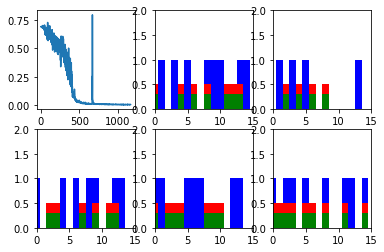

Step 600 Batch loss 0.00224157


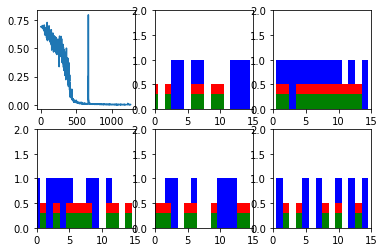

New data, epoch 2
Step 0 Batch loss 0.334025


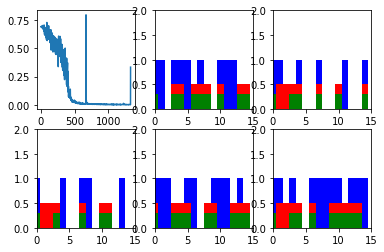

Step 100 Batch loss 0.00180246


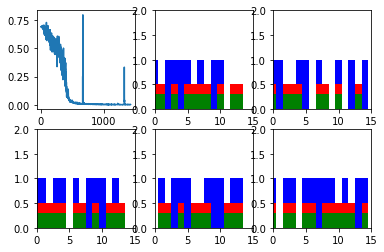

Step 200 Batch loss 0.00180983


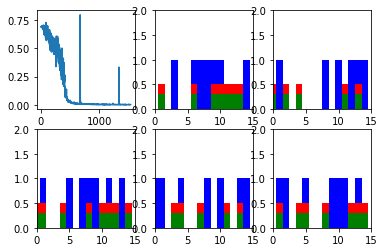

Step 300 Batch loss 0.00094686


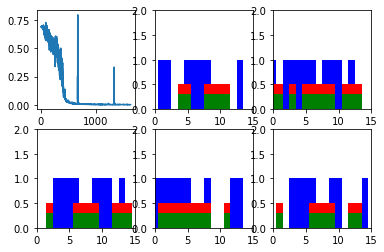

Step 400 Batch loss 0.00135513


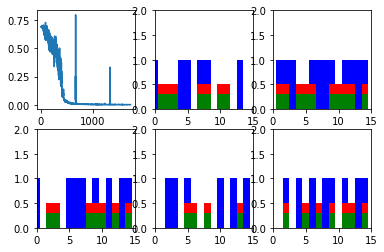

Step 500 Batch loss 0.000861722


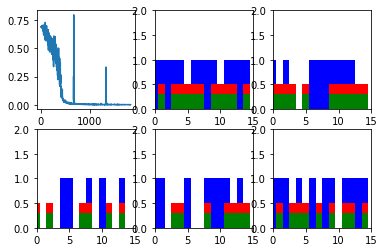

Step 600 Batch loss 0.00084785


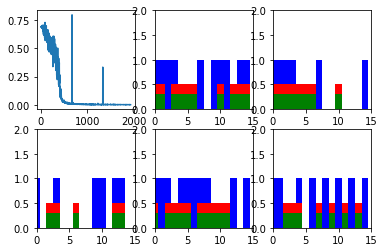

New data, epoch 3
Step 0 Batch loss 0.254923


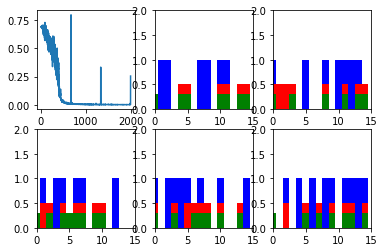

Step 100 Batch loss 0.00117981


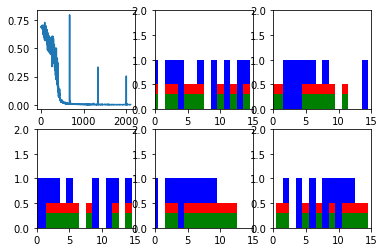

Step 200 Batch loss 0.000820688


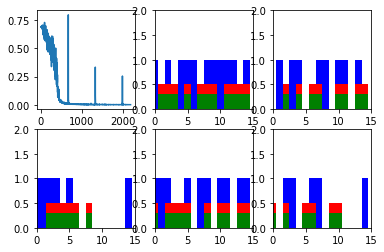

Step 300 Batch loss 0.00113336


KeyboardInterrupt: 

In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, 1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
cell = tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.show()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_cell_state = np.zeros((batch_size, state_size))
        _current_hidden_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    cell_state: _current_cell_state,
                    hidden_state: _current_hidden_state

                })

            _current_cell_state, _current_hidden_state = _current_state

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()